# Transmission Lines Fault

A transmission line fault refers to any abnormal condition or interruption in the normal operation of an electrical transmission line. These faults can manifest as a result of various factors, including equipment malfunctions, environmental conditions (lightning strikes, storms, high winds), or external disturbances (human activities). The most common types of transmission line faults are open circuits and short circuits.

#### Open Circuit Faults (Series)
- This happens when an unintended connection is created between a conductor and the ground, causing an interruption in the electrical path.

#### Short Circuit Faults (Shunt)
- An unintended connection occurs between two conductors, resulting in a low-resistance path for current flow. Short circuits can be classified into two categories:

  ##### Symmetrical Faults
  - All phases experience a short circuit either to each other or to the earth, denoted as (L-L-L) or (L-L-L-G).
  - The fault is balanced, meaning that fault currents in all phases are symmetrical. Their magnitudes are equal and equally displaced by an angle of 120 degrees.
  - Although more severe, symmetrical faults are rare.

  ##### Asymmetrical Faults
  - Involve one or two phases, causing the three-phase lines to become unbalanced.
  - Main types are line-to-ground (L-G), line-to-line (L-L), and double line-to-ground (L-L-G) faults.
  - Asymmetrical faults are more common in power systems.

### About the Dataset
The data used in this study was extracted from a power system modeled in MATLAB to simulate fault analysis. The power system consists of 4 generators of 11 KV, each pair located at each end of the transmission line. Transformers are present to simulate and study various faults at the midpoint of the transmission line.

#### Features of the Dataset
- The dataset consists of the line currents and voltages measurements: [Ia, Ib, Ic, Va, Vb, Vc].

#### Obtaining the Dataset
- After obtaining the dataset from [Electrical Fault Detection and Classification Data - Kaggle Dataset](https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification)
- Create a directory named `transmission_line_fault_detection` and move the files within

#### Target Output
- The binary labeled fault detection dataset indicates whether a fault is present (0 for no fault, 1 for fault).
- The multi-labeled dataset identifies the fault in each line [G, C, B, A]. For example:
  - [0 0 0 0] indicates no fault.
  - [1 0 0 0] indicates a ground fault.
  - [0 0 0 1] indicates a fault in line A.
  - [1 0 1 1] indicates an LLG fault between phases A, B, and the ground.

This dataset can be found on Kaggle [here](https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification).

### Changes Made to the Original Notebooks

1. Expanded the EDA section to provide a more comprehensive understanding of the dataset. This includes detailed visualizations and statistical summaries to uncover patterns and insights.

2. Included extensive observations to facilitate easier interpretation and understanding of the data. Each visualization and analysis step is accompanied by clear and concise observations.

3. Fine-tuned the parameters of the random forest classifier to enhance its performance. Adjustments were made to parameters such as the number of estimators, maximum depth, minimum samples split, and minimum samples leaf to achieve better accuracy and reliability.

### Additional Library Installation

To enhance the functionality of the CTPO environment, you may need to install some libraries not pre-installed but required for this notebook. Follow these steps to install the necessary libraries from the requirements.txt file:

**1. Create and Activate the Virtual Environment:**

Open your terminal or command prompt within the jupyter notebook. `File -> New -> Terminal`

Type `bash` to get access to a shell compatible with the following commands.

Navigate to the project directory where you want to set up the environment.

```bash
cd /path/to/your/project/directory
pwd
```

Execute the following commands to create and activate the virtual environment:

```bash
bash
python3 -m venv --system-site-packages myvenv
source myvenv/bin/activate
pip3 install ipykernel
python -m ipykernel install --user --name=myvenv --name=myvenv --display-name="Python (myvenv)"
``` 

**2. Install Required libraries:**

Before running the following commands, we recommend you load the "Python (myvenv)" kernel in order to limit the chances of altering the underlying container and then make sure you are in the directory where the Jupyter Notebook and the `myvenv` directory are located. This ensures the `./` path is always current. You can use the cd command to change to your project directory and pwd to verify your current directory.




In [1]:
!. ./myvenv/bin/activate; pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


In [3]:
ls ./transmission_line_fault_detection/

classData.csv  detect_dataset.csv


In [4]:
binary_data = pd.read_csv("./transmission_line_fault_detection/detect_dataset.csv")
multiclass_data = pd.read_csv("./transmission_line_fault_detection/classData.csv")

## Binary Fault Detection

In [5]:
binary_data.head(2)

Output (S)          Ia        Ib          Ic       Va        Vb        Vc  \
0           0 -170.472196  9.219613  161.252583  0.05449 -0.659921  0.605431   
1           0 -122.235754  6.168667  116.067087  0.10200 -0.628612  0.526202   

   Unnamed: 7  Unnamed: 8  
0         NaN         NaN  
1         NaN         NaN

In [6]:
binary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12001 entries, 0 to 12000
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Output (S)  12001 non-null  int64  
 1   Ia          12001 non-null  float64
 2   Ib          12001 non-null  float64
 3   Ic          12001 non-null  float64
 4   Va          12001 non-null  float64
 5   Vb          12001 non-null  float64
 6   Vc          12001 non-null  float64
 7   Unnamed: 7  0 non-null      float64
 8   Unnamed: 8  0 non-null      float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [7]:
binary_data.drop(['Unnamed: 7','Unnamed: 8'],axis=1,inplace=True)

In [8]:
#checking if dataset is balance or not
binary_data['Output (S)'].value_counts()

Output (S)
0    6505
1    5496
Name: count, dtype: int64

### Exploratory Data Analysis

In [9]:
data_eda = binary_data.copy()
data_eda["Output"] = data_eda["Output (S)"].map({0: "No Fault", 1: "Fault"})

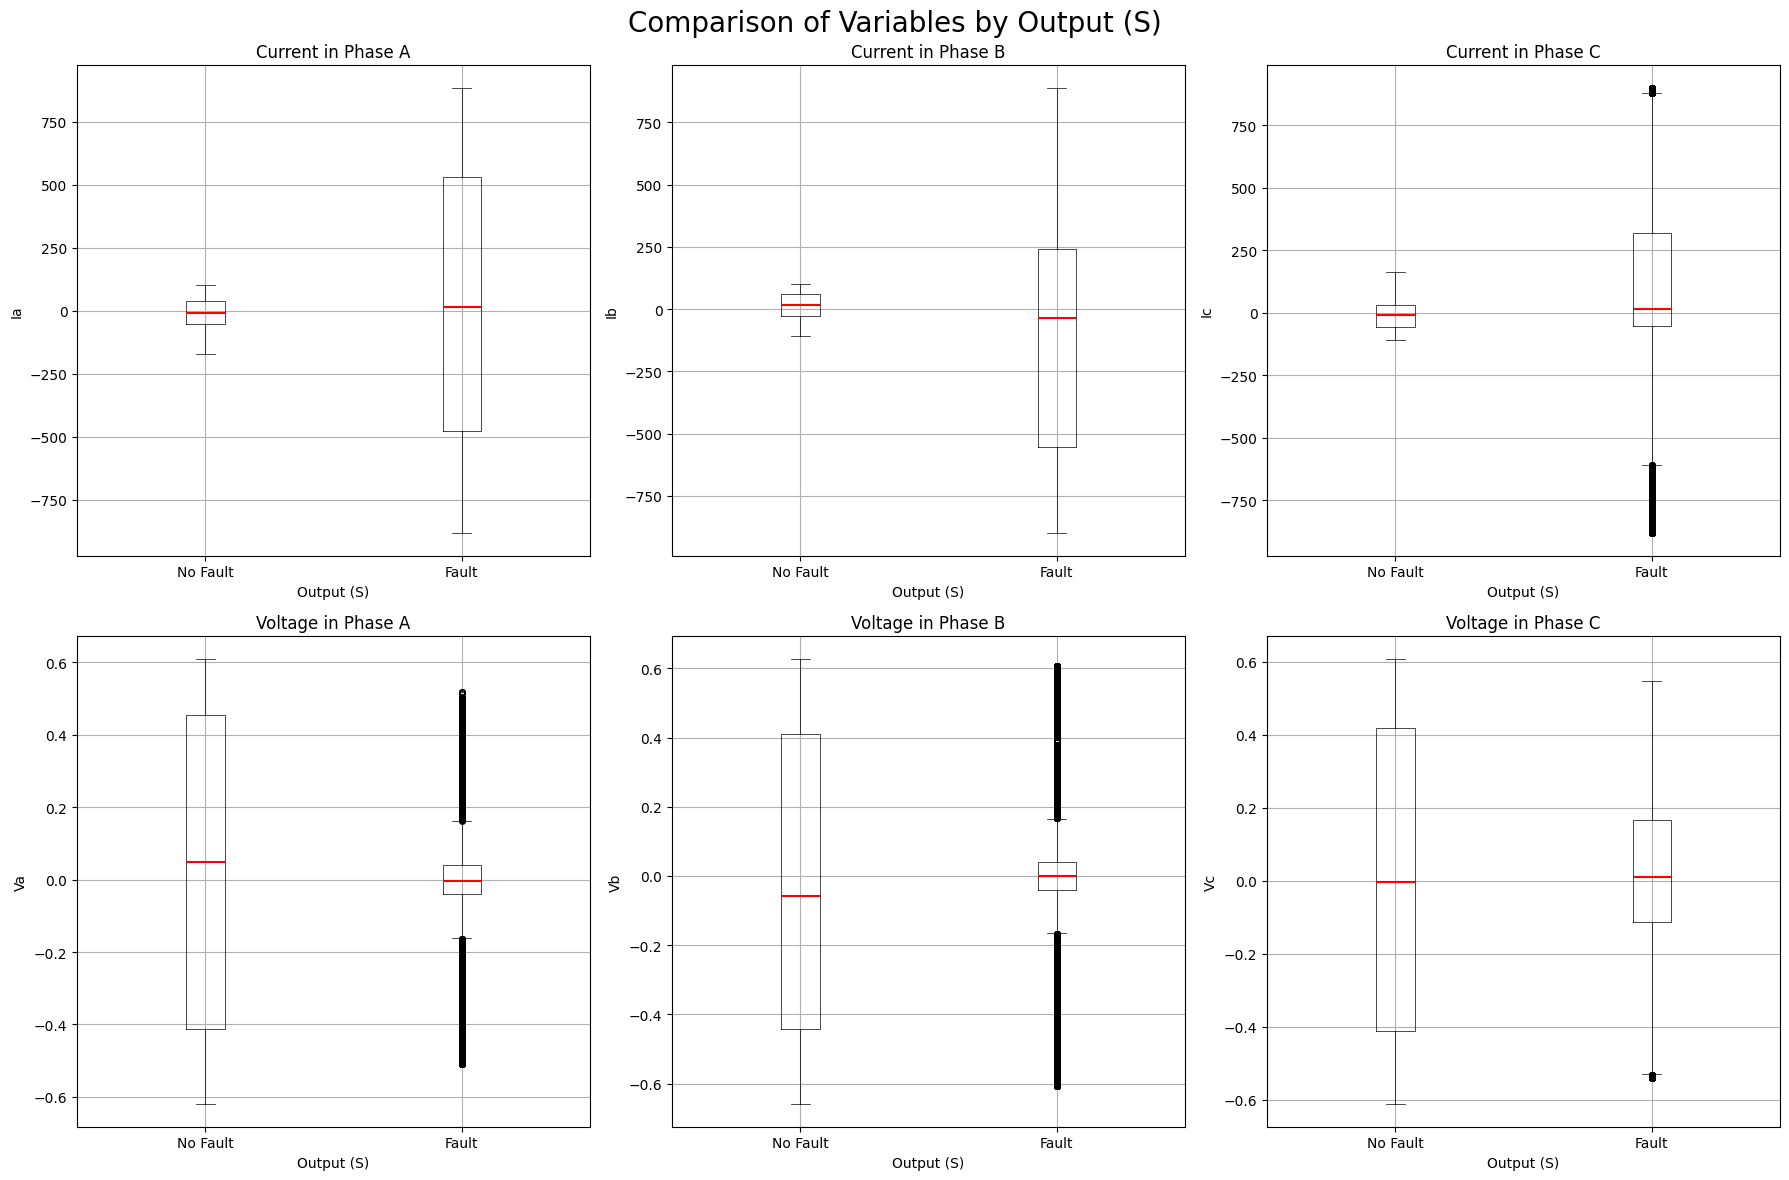

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
variables = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']

# Dictionary to map variables to their descriptions
variable_descriptions = {
    'Ia': 'Current in Phase A',
    'Ib': 'Current in Phase B',
    'Ic': 'Current in Phase C',
    'Va': 'Voltage in Phase A',
    'Vb': 'Voltage in Phase B',
    'Vc': 'Voltage in Phase C'
}

for i, var in enumerate(variables):
    row, col = divmod(i, 3)
    data_eda.boxplot(
        column=var, 
        by='Output (S)', 
        ax=axes[row, col],
        whiskerprops=dict(linestyle='-', linewidth=0.5, color='black'),
        capprops=dict(linestyle='-', linewidth=0.5, color='black'),
        boxprops=dict(linestyle='-', linewidth=0.5, color='black'),
        medianprops=dict(linestyle='-', linewidth=1.5, color='red'),
        flierprops=dict(marker='o', markersize=4, linestyle='none', color='black')
    )
    # Set title with variable description
    axes[row, col].set_title(f'{variable_descriptions[var]}')
    axes[row, col].set_xlabel('Output (S)')
    axes[row, col].set_ylabel(var)
    axes[row, col].set_xticklabels(['No Fault', 'Fault'])

plt.suptitle('Comparison of Variables by Output (S)',fontsize=20)
plt.tight_layout()
plt.show()


**Current Measurements (Ia, Ib, Ic)**:

**Phase A (Ia)**: The current in phase A shows a wider range and higher median value during faults compared to no faults. This indicates that the current increases significantly when a fault occurs.

**Phase B (Ib)**: Similar to phase A, the current in phase B also shows a significant increase and wider range during faults.

**Phase C (Ic)**: The current in phase C exhibits a similar pattern, with a noticeable increase in current values and a wider range during faults.

**Voltage Measurements (Va, Vb, Vc)**:

**Phase A (Va)**: The voltage in phase A appears to have a slightly lower median and a narrower interquartile range during faults compared to no faults, indicating a possible drop in voltage during faults.

**Phase B (Vb)**: The voltage in phase B shows a similar pattern to phase A, with a lower median and reduced spread during faults.

**Phase C (Vc)**: The voltage in phase C also displays a decrease in the median and a narrower interquartile range during faults, suggesting a voltage drop during fault conditions

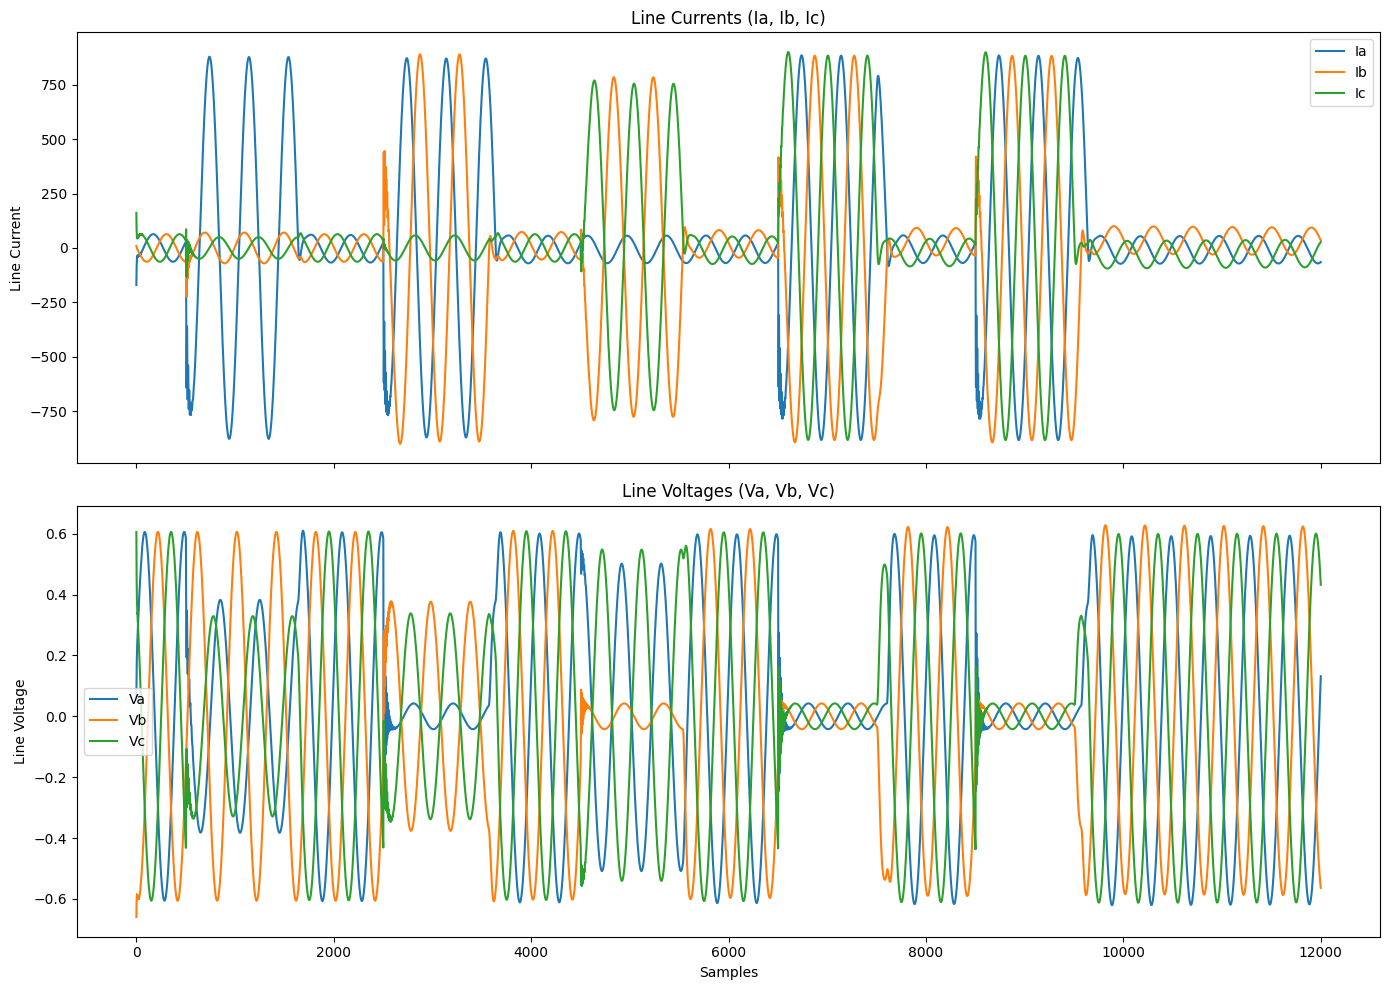

In [11]:
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(14, 10))

# Plot currents
data_eda["Ia"].plot(ax=axs[0], label="Ia")
data_eda["Ib"].plot(ax=axs[0], label="Ib")
data_eda["Ic"].plot(ax=axs[0], label="Ic")
axs[0].set_ylabel("Line Current")
axs[0].set_title("Line Currents (Ia, Ib, Ic)")
axs[0].legend()

# Plot voltages
data_eda["Va"].plot(ax=axs[1], label="Va")
data_eda["Vb"].plot(ax=axs[1], label="Vb")
data_eda["Vc"].plot(ax=axs[1], label="Vc")
axs[1].set_ylabel("Line Voltage")
axs[1].set_title("Line Voltages (Va, Vb, Vc)")
axs[1].legend()

plt.xlabel("Samples")
plt.tight_layout()
plt.show()


- Significant spikes and dips in line currents (`Ia`, `Ib`, `Ic`) suggest potential fault conditions with sharp increases in current.
- Line voltages (`Va`, `Vb`, `Vc`) remain relatively stable with minor disturbances, indicating less impact from faults compared to currents.
- Both currents and voltages exhibit synchronous patterns across phases, indicating cohesive functioning of the three-phase system during disturbances.

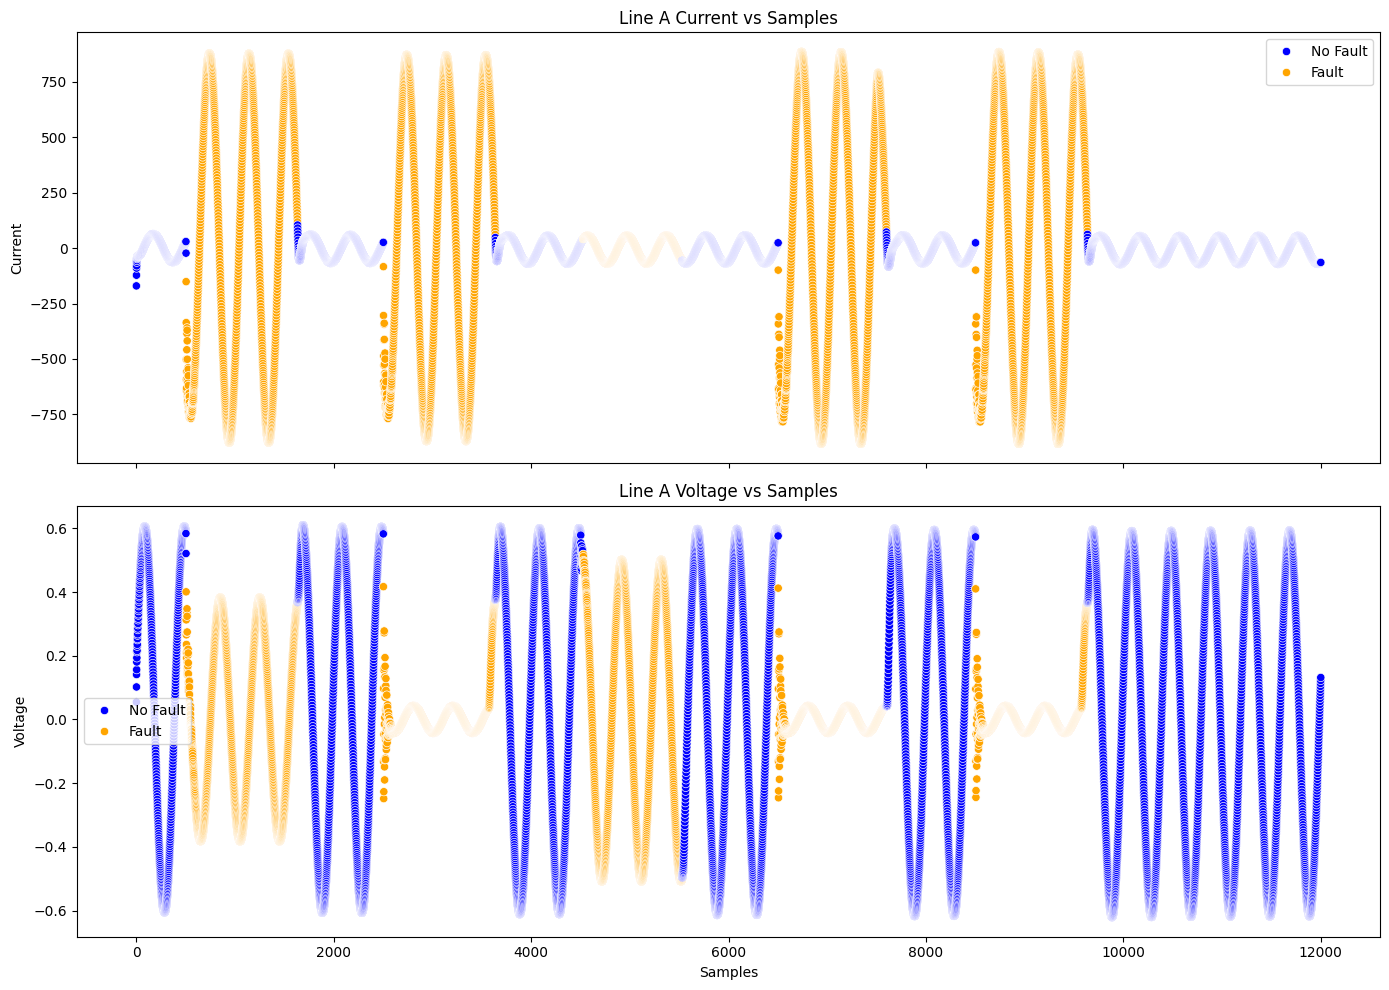

In [12]:
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(14, 10))

# Scatter plots
sns.scatterplot(data=data_eda, y="Ia", x=data_eda.index, hue='Output (S)', ax=axs[0], palette={0: "blue", 1: "orange"})
sns.scatterplot(data=data_eda, y="Va", x=data_eda.index, hue='Output (S)', ax=axs[1], palette={0: "blue", 1: "orange"})

# Setting labels and titles
axs[0].set_ylabel("Current")
axs[0].set_title("Line A Current vs Samples")
axs[1].set_ylabel("Voltage")
axs[1].set_title("Line A Voltage vs Samples")

plt.xlabel("Samples")

# Customize legends
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, ['No Fault', 'Fault'])
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, ['No Fault', 'Fault'])

plt.tight_layout()
plt.show()

**Current Behavior**: Faults are associated with higher magnitudes and more variability in the current (Ia) compared to periods with no faults, indicating that faults cause significant disturbances in the current.

**Voltage Stability**: Voltage (Va) shows less variation during faults compared to the current. However, there are distinct patterns where the voltage drops slightly during fault conditions.


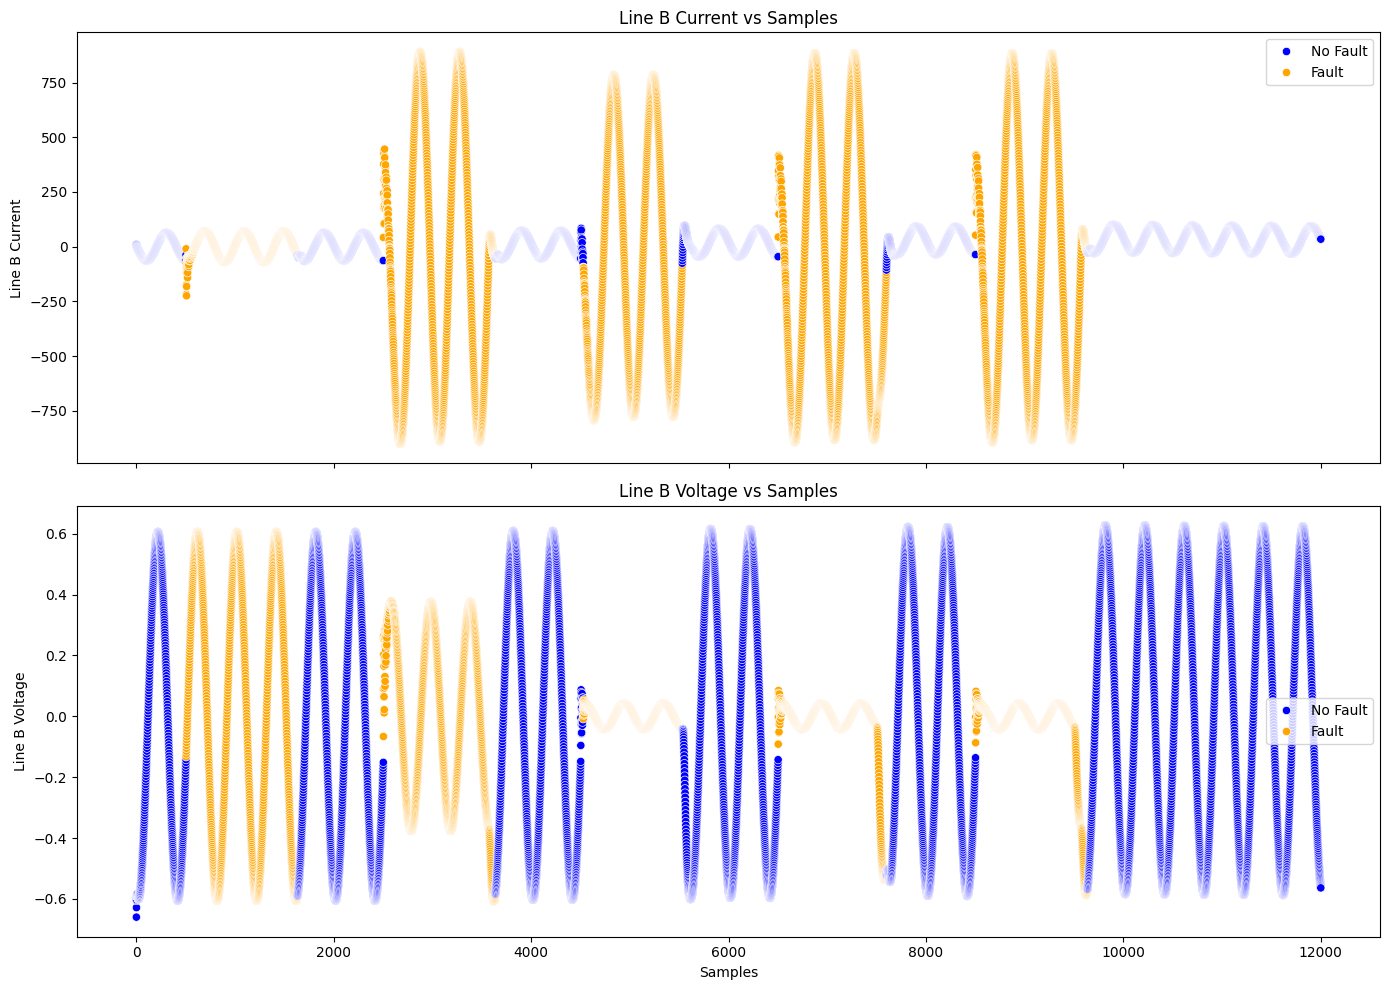

In [13]:
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(14, 10))

# Scatter plots for Line B
sns.scatterplot(data=data_eda, y="Ib", x=data_eda.index, hue='Output (S)', ax=axs[0], palette={0: "blue", 1: "orange"})
sns.scatterplot(data=data_eda, y="Vb", x=data_eda.index, hue='Output (S)', ax=axs[1], palette={0: "blue", 1: "orange"})

# Setting labels and titles
axs[0].set_ylabel("Line B Current")
axs[0].set_title("Line B Current vs Samples")
axs[1].set_ylabel("Line B Voltage")
axs[1].set_title("Line B Voltage vs Samples")

plt.xlabel("Samples")

for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['No Fault', 'Fault'])

plt.tight_layout()
plt.show()

**Current Behavior**: Faults are associated with higher magnitudes and more variability in the Line B current, indicating significant disturbances during fault conditions. The current waveform exhibits notable deviations from its regular pattern when faults occur.

**Voltage Stability**: The Line B voltage shows relatively stable behavior with less variation compared to the current during fault conditions. However, there are distinct patterns where the voltage waveform displays slight drops during faults, highlighting the impact of fault events on the voltage stability.

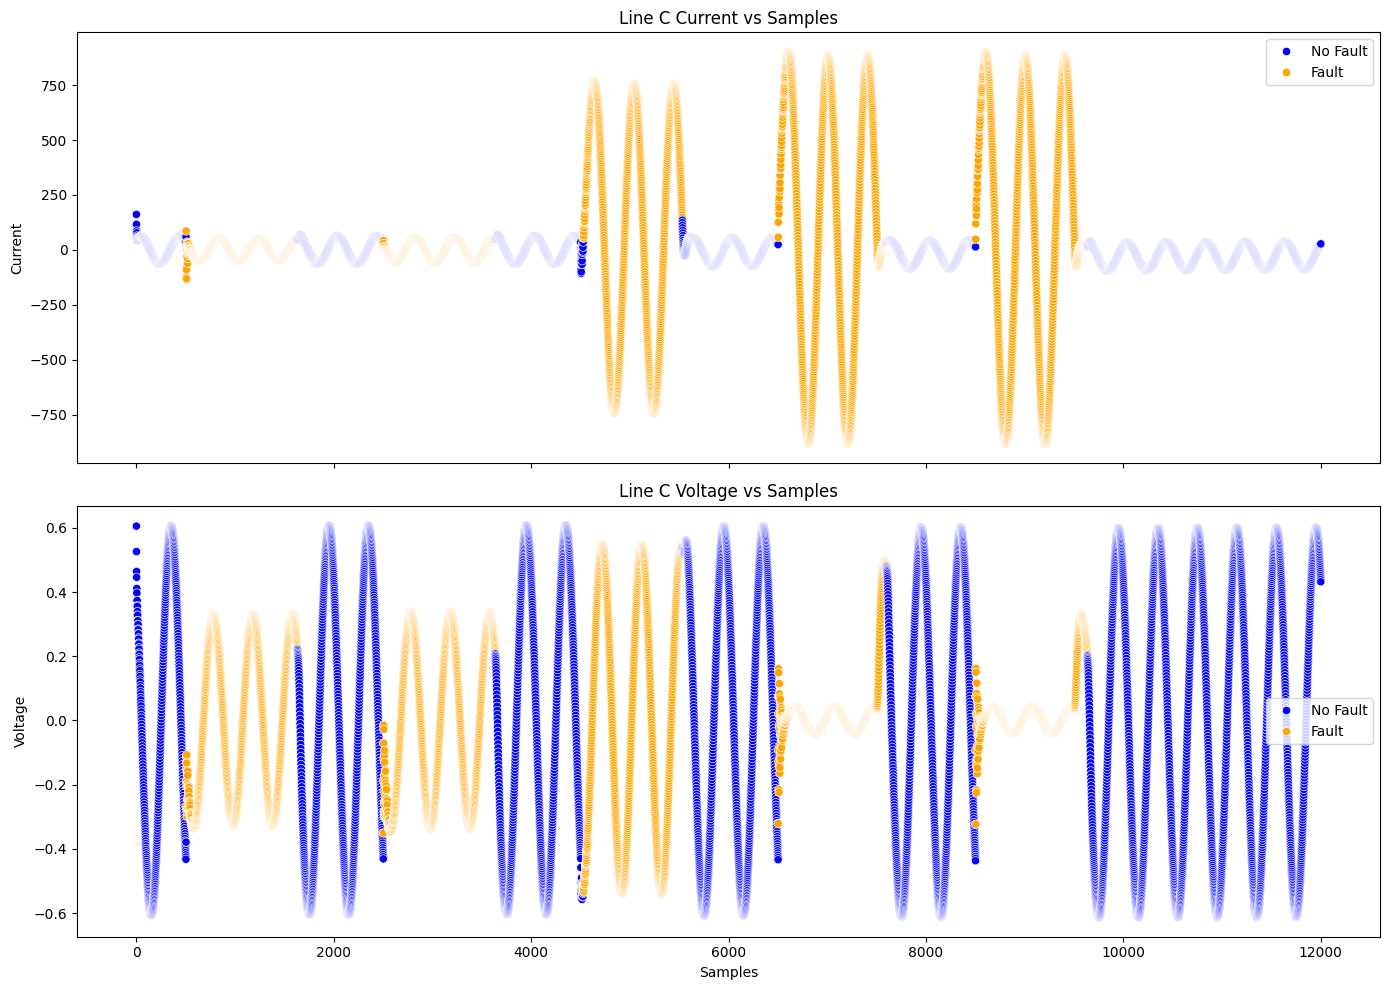

In [14]:
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(14, 10))


# Scatter plots for Line C
sns.scatterplot(data=data_eda, y="Ic", x=data_eda.index, hue='Output (S)', ax=axs[0], palette={0: "blue", 1: "orange"})
sns.scatterplot(data=data_eda, y="Vc", x=data_eda.index, hue='Output (S)', ax=axs[1], palette={0: "blue", 1: "orange"})
axs[0].set_ylabel("Current")
axs[0].set_title("Line C Current vs Samples")
axs[1].set_ylabel("Voltage")
axs[1].set_title("Line C Voltage vs Samples")

plt.xlabel("Samples")

# Customize legends
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['No Fault', 'Fault'])

plt.tight_layout()
plt.show()

**Current Behavior:** Faults in Line C are associated with significantly higher magnitudes and increased variability in the current compared to periods with no faults. This indicates that fault conditions cause substantial disruptions in the current flow.

**Voltage Stability:** Line C voltage displays less variation during fault conditions than the current. However, distinct patterns show slight drops in the voltage waveform during faults, highlighting the impact of faults on voltage stability.

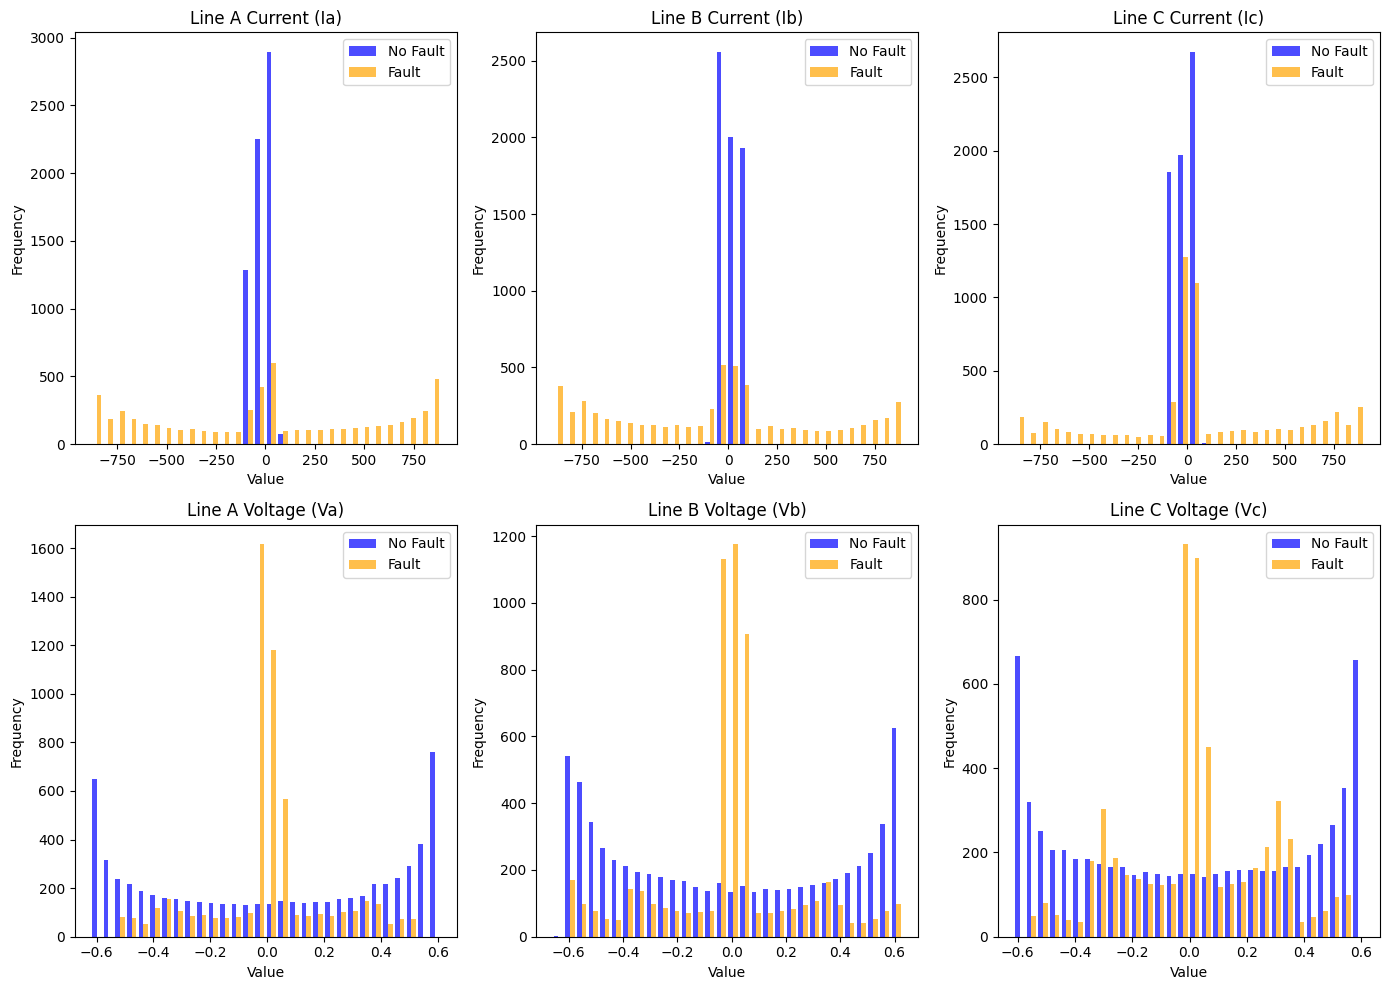

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

# Plot histograms for Line A, B, and C currents
axes[0, 0].hist([data_eda[data_eda['Output (S)'] == 0]['Ia'], data_eda[data_eda['Output (S)'] == 1]['Ia']], bins=30, color=['blue', 'orange'], label=['No Fault', 'Fault'], alpha=0.7)
axes[0, 1].hist([data_eda[data_eda['Output (S)'] == 0]['Ib'], data_eda[data_eda['Output (S)'] == 1]['Ib']], bins=30, color=['blue', 'orange'], label=['No Fault', 'Fault'], alpha=0.7)
axes[0, 2].hist([data_eda[data_eda['Output (S)'] == 0]['Ic'], data_eda[data_eda['Output (S)'] == 1]['Ic']], bins=30, color=['blue', 'orange'], label=['No Fault', 'Fault'], alpha=0.7)

# Plot histograms for Line A, B, and C voltages
axes[1, 0].hist([data_eda[data_eda['Output (S)'] == 0]['Va'], data_eda[data_eda['Output (S)'] == 1]['Va']], bins=30, color=['blue', 'orange'], label=['No Fault', 'Fault'], alpha=0.7)
axes[1, 1].hist([data_eda[data_eda['Output (S)'] == 0]['Vb'], data_eda[data_eda['Output (S)'] == 1]['Vb']], bins=30, color=['blue', 'orange'], label=['No Fault', 'Fault'], alpha=0.7)
axes[1, 2].hist([data_eda[data_eda['Output (S)'] == 0]['Vc'], data_eda[data_eda['Output (S)'] == 1]['Vc']], bins=30, color=['blue', 'orange'], label=['No Fault', 'Fault'], alpha=0.7)

# Set titles and labels
axes[0, 0].set_title('Line A Current (Ia)')
axes[0, 1].set_title('Line B Current (Ib)')
axes[0, 2].set_title('Line C Current (Ic)')
axes[1, 0].set_title('Line A Voltage (Va)')
axes[1, 1].set_title('Line B Voltage (Vb)')
axes[1, 2].set_title('Line C Voltage (Vc)')

for ax in axes.flat:
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()


**Current Distribution:** Fault conditions are associated with higher variability and more extreme values in the current for all lines (Ia, Ib, Ic), compared to periods with no faults, which show a more centralized distribution.

**Voltage Distribution:** The voltage values for all lines (Va, Vb, Vc) also exhibit increased variability during fault conditions, though the shifts are less pronounced compared to the currents, indicating distinct but less extreme deviations from the norm.

<Axes: >

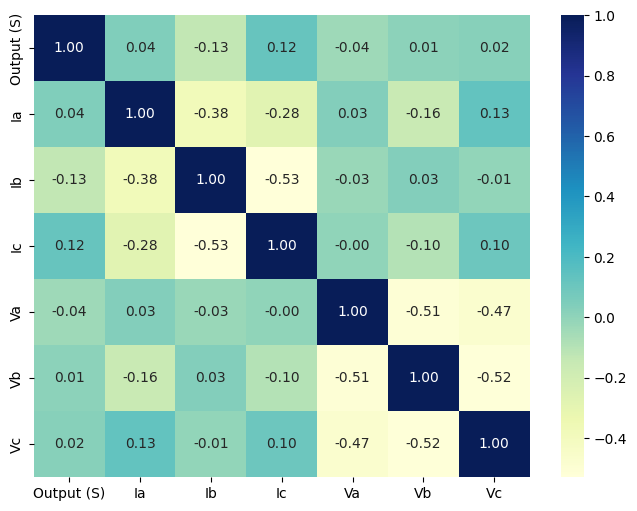

In [16]:
# Let's see the correlation between our features
plt.figure(figsize=(8, 6))
sns.heatmap(binary_data.corr(), cmap='YlGnBu', fmt='.2f', annot=True)

**Current Correlations:** The currents in Line A (Ia) and Line B (Ib) show a moderate negative correlation (-0.38), and Line B (Ib) and Line C (Ic) also have a notable negative correlation (-0.53), indicating that when the current in one line increases, the current in the other line tends to decrease.

**Voltage Correlations:** The voltages across the lines show strong negative correlations, particularly between Va and Vb (-0.51), Va and Vc (-0.47), and Vb and Vc (-0.52), suggesting that the voltages in these lines tend to move in opposite directions.

**Output Relationships:** The output (S) has a weak correlation with all other variables, indicating that it is influenced by multiple factors with no single dominant variable.

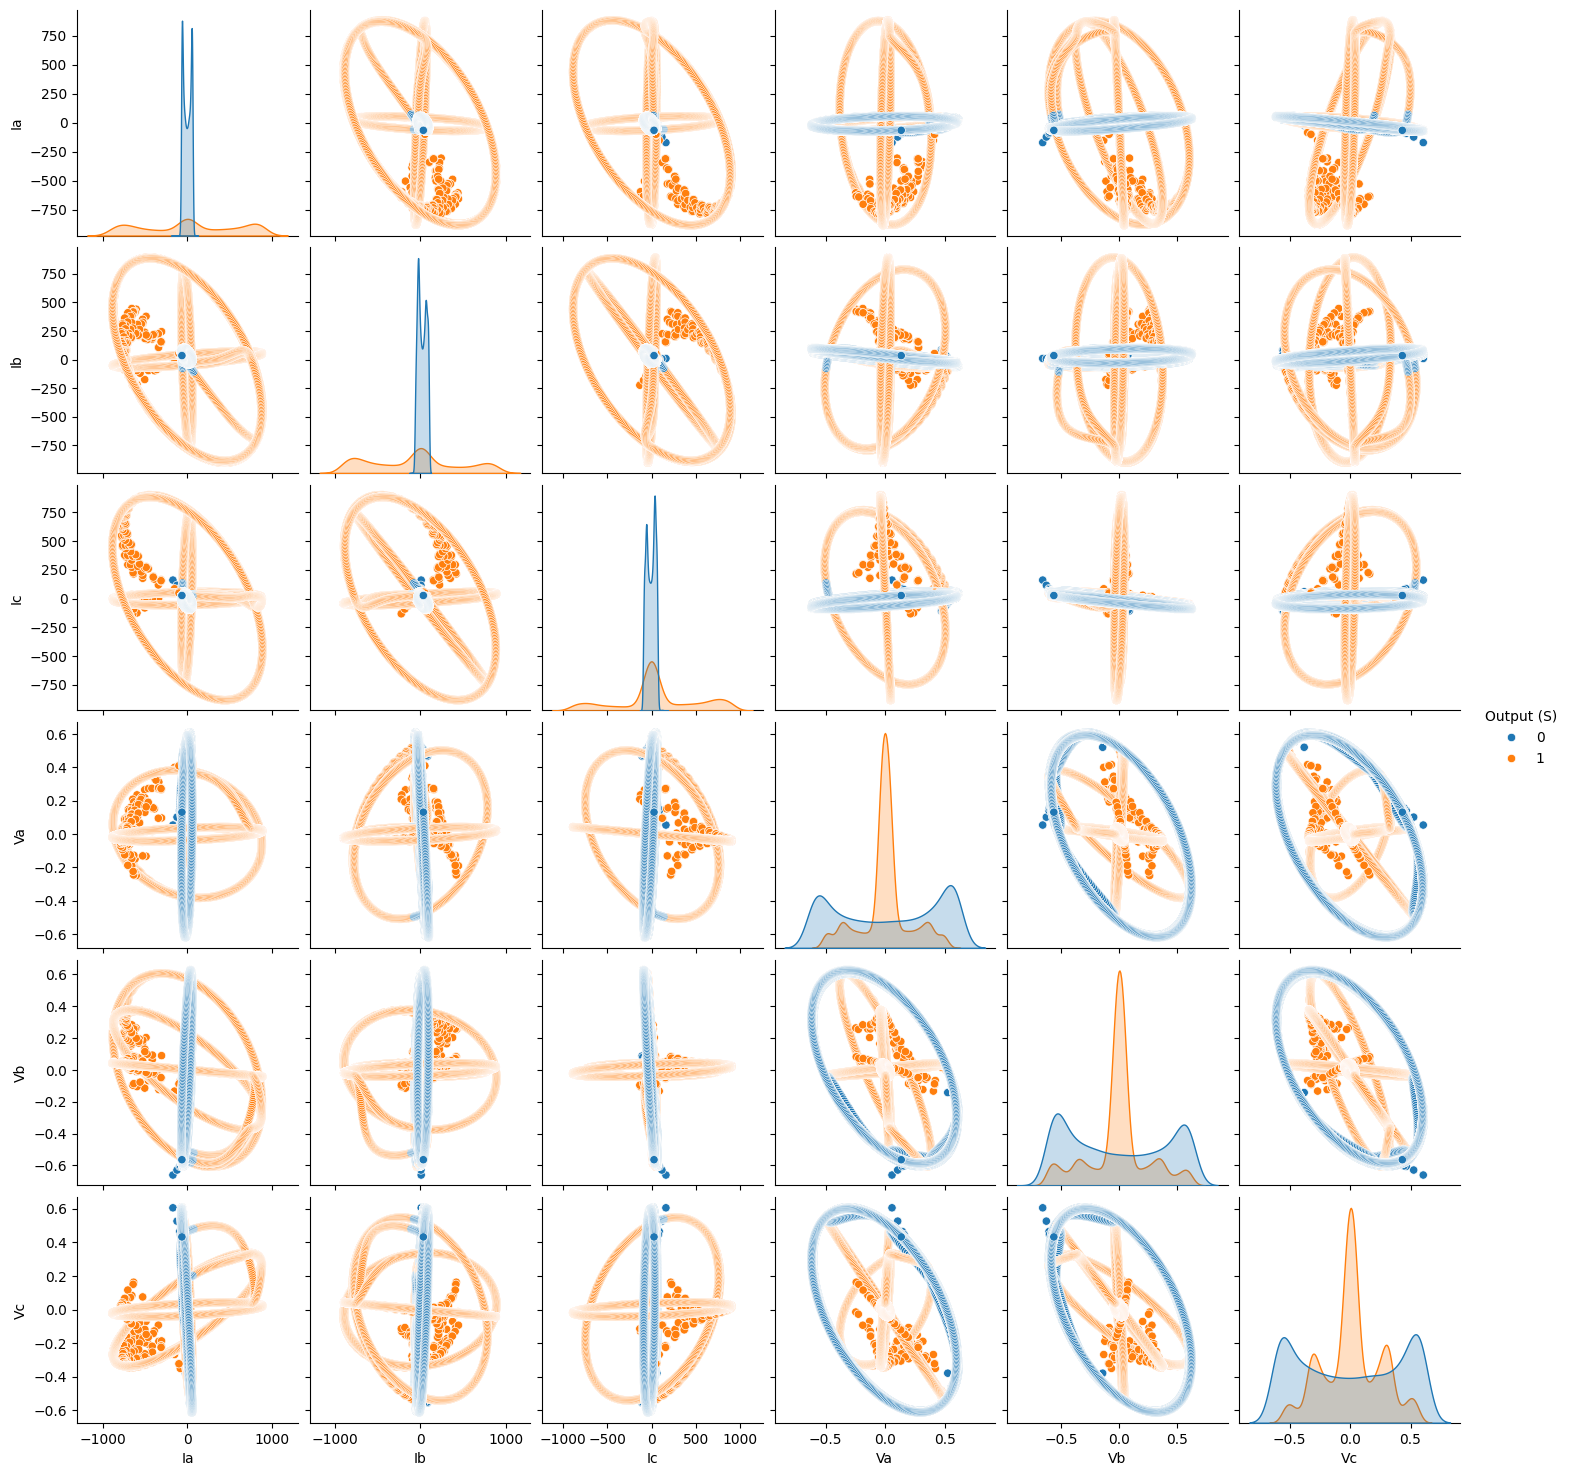

In [17]:
# plot features distribution
sns.pairplot(binary_data, hue='Output (S)')

The pair plot indicates distinct clustering of data points for fault (orange) and no-fault (blue) conditions, with noticeable separation in certain feature combinations, suggesting that the features can effectively distinguish between the two states.

There are visible correlations between certain pairs of features, such as the currents (Ia, Ib, Ic) and voltages (Va, Vb, Vc), as indicated by the elliptical shapes in the scatter plots. This suggests a relationship between the current and voltage behaviors.

The diagonal plots show the distribution of individual features, highlighting that fault conditions tend to have a broader distribution and more extreme values compared to no-fault conditions, which have a more centralized distribution.

## Building Machine Learning Model

In [18]:
target = binary_data["Output (S)"]
X = binary_data.drop(["Output (S)"], axis=1)

In [19]:
# Split the dataset: Training(80%), Testing(20%)
x_train, x_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=0)

In [20]:
labels = ["No Fault", "Fault"]

def accuracy_logs(y_test, y_pred):
    print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
    print("Metrics table:\n", classification_report(y_test, y_pred, target_names=labels))

def draw_confusion_matrix(y_test, y_pred):
    matrix = confusion_matrix(y_test, y_pred)
    matrix = pd.DataFrame(matrix, index=labels, columns=labels)
    plt.figure(figsize=(6, 4))
    plot = sns.heatmap(matrix,  fmt='.2f', annot=True)
    plot.set_xlabel('Predicted')
    plot.set_ylabel('Real')

# Logistic Regression Classifier

In [21]:
lrg_clf = LogisticRegression()
lrg_clf.fit(x_train, y_train)
y_pred = lrg_clf.predict(x_test)

In [22]:
accuracy_logs(y_test, y_pred)


Accuracy score: 0.7396917950853811
Metrics table:
               precision    recall  f1-score   support

    No Fault       0.68      1.00      0.81      1325
       Fault       1.00      0.42      0.59      1076

    accuracy                           0.74      2401
   macro avg       0.84      0.71      0.70      2401
weighted avg       0.82      0.74      0.71      2401



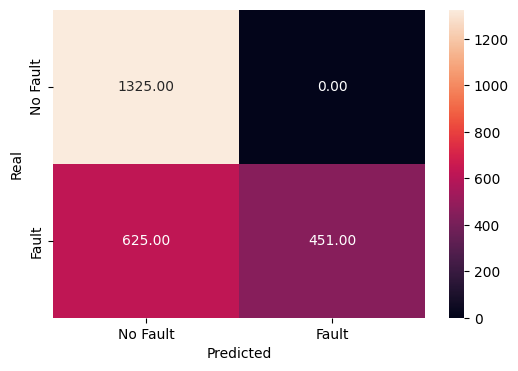

In [23]:
draw_confusion_matrix(y_test, y_pred)

The model achieves high precision but lower recall for detecting faults, indicating it correctly identifies most no-fault conditions but misses many fault conditions, as shown by the significant number of false negatives in the confusion matrix.

# Support Vector Machine

In [24]:
svc_clf = SVC()
svc_clf.fit(x_train, y_train)
y_pred = svc_clf.predict(x_test)
accuracy_logs(y_test, y_pred)

Accuracy score: 0.9775093710953769
Metrics table:
               precision    recall  f1-score   support

    No Fault       0.96      1.00      0.98      1325
       Fault       1.00      0.95      0.97      1076

    accuracy                           0.98      2401
   macro avg       0.98      0.97      0.98      2401
weighted avg       0.98      0.98      0.98      2401



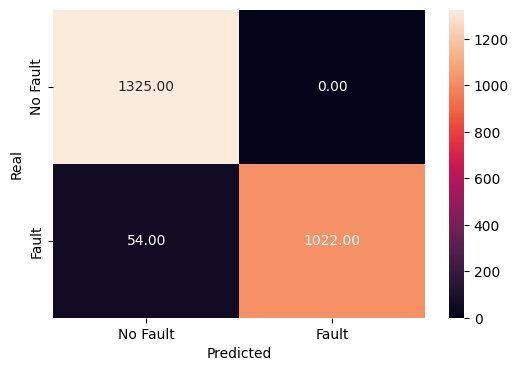

In [25]:
draw_confusion_matrix(y_test, y_pred)


This model shows high accuracy, with both fault and no-fault conditions being correctly classified most of the time, as evidenced by the minimal number of misclassifications in the confusion matrix.

# Decision Tree Classifier

In [26]:
tree_clf = DecisionTreeClassifier(random_state=0)
tree_clf.fit(x_train, y_train)
y_pred = tree_clf.predict(x_test)
accuracy_logs(y_test, y_pred)

Accuracy score: 0.9933361099541858
Metrics table:
               precision    recall  f1-score   support

    No Fault       0.99      1.00      0.99      1325
       Fault       1.00      0.99      0.99      1076

    accuracy                           0.99      2401
   macro avg       0.99      0.99      0.99      2401
weighted avg       0.99      0.99      0.99      2401



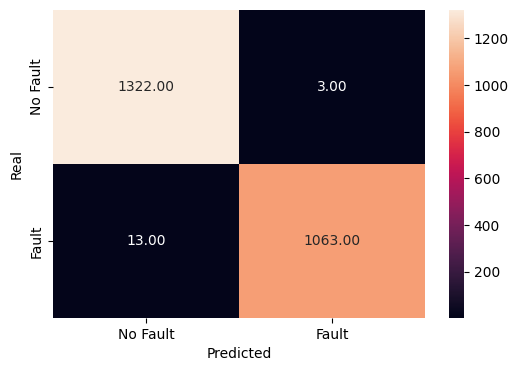

In [27]:
draw_confusion_matrix(y_test, y_pred)

This model demonstrates an accuracy of 99%, characterized by high precision and recall metrics across both fault and no-fault classes, as evidenced by the confusion matrix showing minimal misclassification errors.

# Random Forest Classifier

In [28]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(x_train, y_train)
y_pred = rf_clf.predict(x_test)
accuracy_logs(y_test, y_pred)

Accuracy score: 0.9941690962099126
Metrics table:
               precision    recall  f1-score   support

    No Fault       0.99      1.00      0.99      1325
       Fault       1.00      0.99      0.99      1076

    accuracy                           0.99      2401
   macro avg       0.99      0.99      0.99      2401
weighted avg       0.99      0.99      0.99      2401



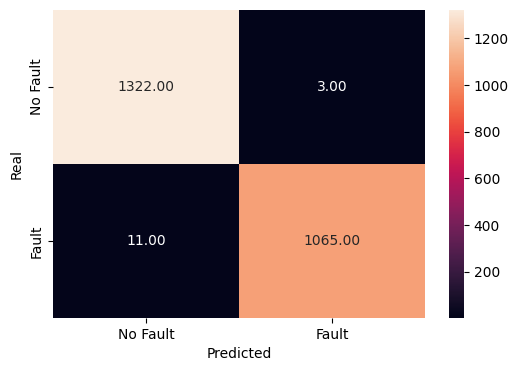

In [29]:
draw_confusion_matrix(y_test, y_pred)


The model achieves an impressive accuracy of 99%, exhibiting high precision and recall for both fault and no-fault classes. The confusion matrix confirms its robust performance, with a minimal number of misclassifications, indicating the model's effectiveness in accurately detecting fault conditions.

# XGBoost Classifier


In [30]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train, y_train)
y_pred = xgb_clf.predict(x_test)
accuracy_logs(y_test, y_pred)

Accuracy score: 0.9941690962099126
Metrics table:
               precision    recall  f1-score   support

    No Fault       0.99      1.00      0.99      1325
       Fault       1.00      0.99      0.99      1076

    accuracy                           0.99      2401
   macro avg       0.99      0.99      0.99      2401
weighted avg       0.99      0.99      0.99      2401



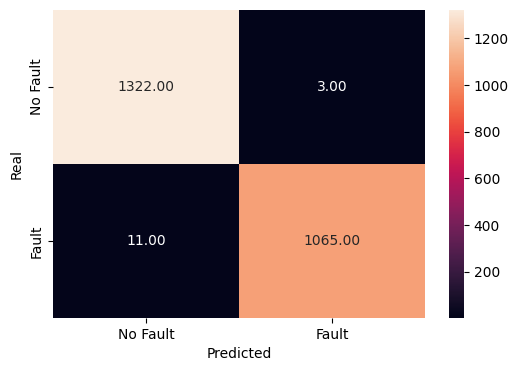

In [31]:
draw_confusion_matrix(y_test, y_pred)

The XGBoost Classifier model achieves a high accuracy of 99%, with excellent precision and recall for both fault and no-fault classes. The confusion matrix reflects the model's robust performance, showing minimal misclassifications, thus confirming its effectiveness in accurately detecting fault conditions.

# Multi class fault detection
In this classification problem, the goal is to predict the type of fault occurring based on the currents and voltages observed in the three phases (A, B, C).

In [32]:
multiclass_data.head()

G  C  B  A          Ia          Ib          Ic        Va        Vb  \
0  1  0  0  1 -151.291812   -9.677452   85.800162  0.400750 -0.132935   
1  1  0  0  1 -336.186183  -76.283262   18.328897  0.312732 -0.123633   
2  1  0  0  1 -502.891583 -174.648023  -80.924663  0.265728 -0.114301   
3  1  0  0  1 -593.941905 -217.703359 -124.891924  0.235511 -0.104940   
4  1  0  0  1 -643.663617 -224.159427 -132.282815  0.209537 -0.095554   

         Vc  
0 -0.267815  
1 -0.189099  
2 -0.151428  
3 -0.130570  
4 -0.113983

In [33]:
multiclass_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7861 entries, 0 to 7860
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   G       7861 non-null   int64  
 1   C       7861 non-null   int64  
 2   B       7861 non-null   int64  
 3   A       7861 non-null   int64  
 4   Ia      7861 non-null   float64
 5   Ib      7861 non-null   float64
 6   Ic      7861 non-null   float64
 7   Va      7861 non-null   float64
 8   Vb      7861 non-null   float64
 9   Vc      7861 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 614.3 KB


In [34]:
multiclass_data["fault_class"] = multiclass_data.apply(lambda x: f'{int(x["G"])}{int(x["A"])}{int(x["B"])}{int(x["C"])}', axis=1)
multiclass_data["fault_class"].value_counts()

fault_class
0000    2365
1110    1134
1111    1133
1100    1129
0111    1096
0011    1004
Name: count, dtype: int64

# Exploratory Data Analysis

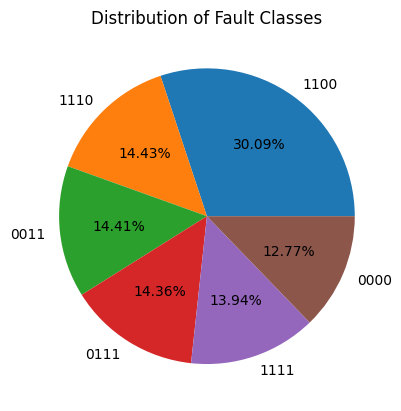

In [35]:
plt.pie(multiclass_data["fault_class"].value_counts(), labels=multiclass_data["fault_class"].unique(),autopct='%1.2f%%')
plt.title('Distribution of Fault Classes')
plt.show()


- From the above chart we can observe balanced distribution of fault classes, with class '1100' being the most frequent at 30.09%, followed by other classes each representing approximately 12-14% of the data.

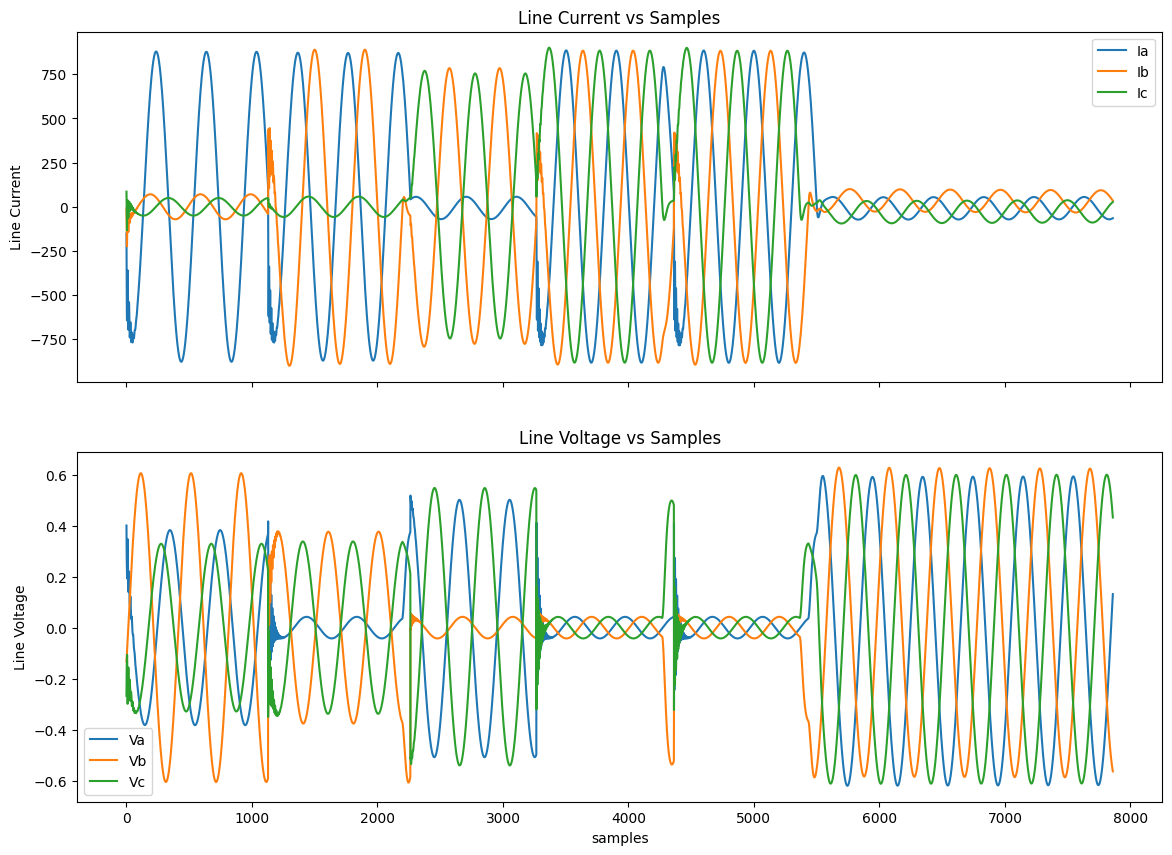

In [36]:
df_eda = multiclass_data.copy()

# as we did previously let's plot the lines currents and voltages
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(14, 10))
df_eda["Ia"].plot(ax=axs[0])
df_eda["Ib"].plot(ax=axs[0])
df_eda["Ic"].plot(ax=axs[0])
df_eda["Va"].plot(ax=axs[1])
df_eda["Vb"].plot(ax=axs[1])
df_eda["Vc"].plot(ax=axs[1])
axs[0].set_ylabel("Line Current")
axs[1].set_ylabel("Line Voltage")
axs[0].set_title("Line Current vs Samples")
axs[1].set_title("Line Voltage vs Samples")
plt.xlabel("samples")
axs[0].legend()
axs[1].legend()
plt.show()

- **Current Fluctuations:** The Line Current plot shows significant oscillations and phase shifts in the currents (Ia, Ib, Ic) at various points, indicating dynamic changes and possible disturbances in the transmission lines.
  
- **Voltage Variations:** The Line Voltage plot similarly exhibits oscillations and shifts in the voltages (Va, Vb, Vc), with notable changes corresponding to those seen in the current plot, suggesting simultaneous disturbances affecting both current and voltage.
  
- **Phase Consistency:** Despite fluctuations, there is an overall consistency in the phase relationships between the lines, indicating that the faults or disturbances affect all lines but maintain their relative phases.

# Line A

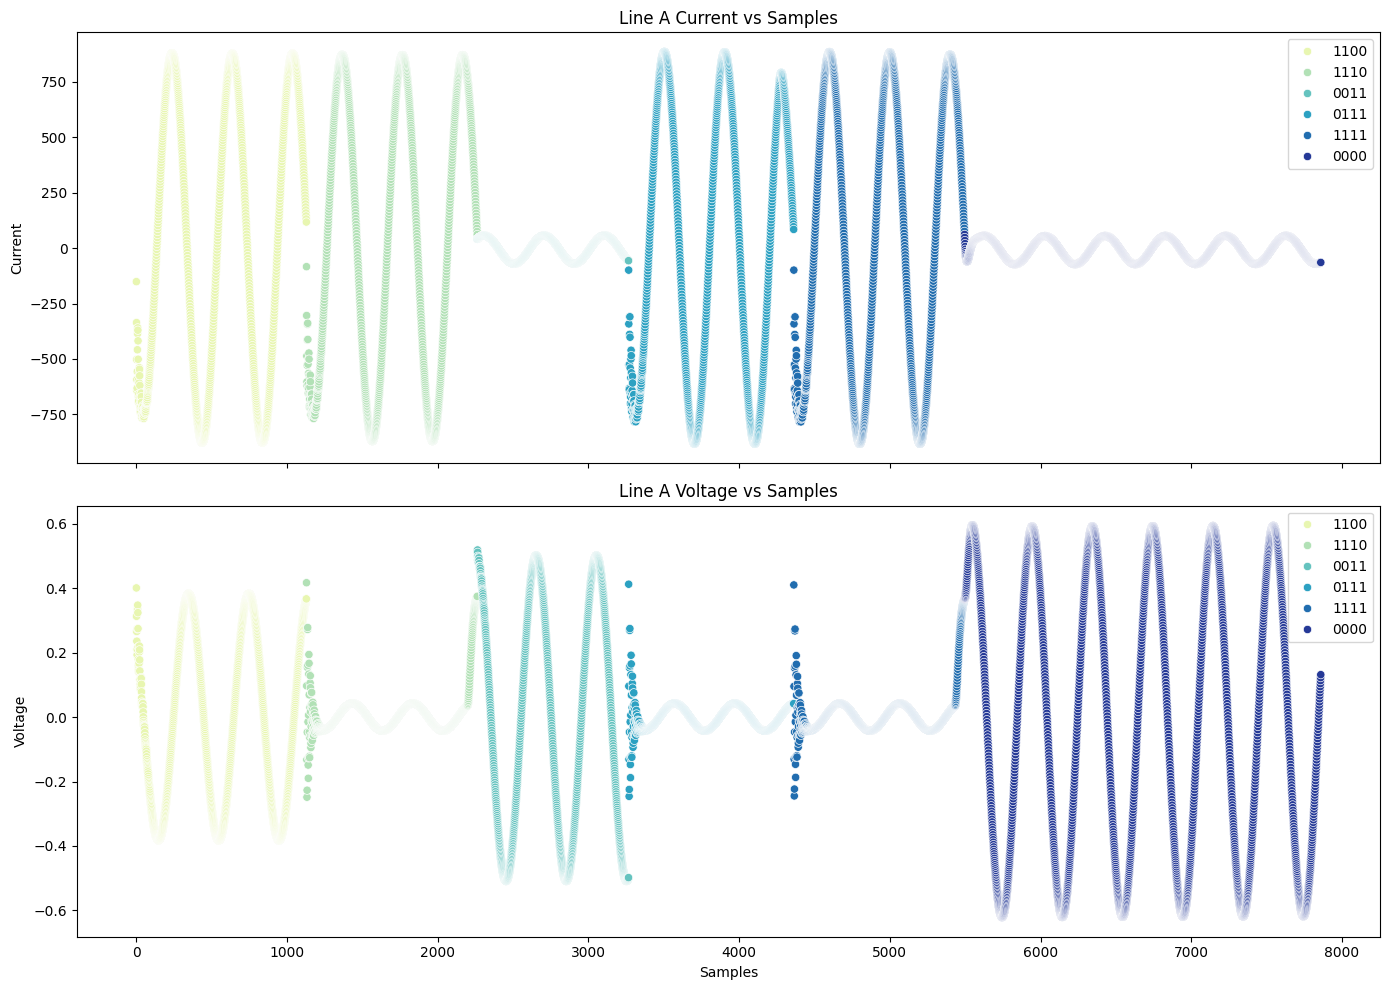

In [37]:
palette = sns.color_palette("YlGnBu", n_colors=6)

# Create the scatter plots
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(14, 10))

sns.scatterplot(data=multiclass_data, y="Ia", x=multiclass_data.index, hue='fault_class', palette=palette, ax=axs[0])
sns.scatterplot(data=multiclass_data, y="Va", x=multiclass_data.index, hue='fault_class', palette=palette, ax=axs[1])

# Set labels and titles
axs[0].set_ylabel("Current")
axs[0].set_title("Line A Current vs Samples")
axs[1].set_ylabel("Voltage")
axs[1].set_title("Line A Voltage vs Samples")

plt.xlabel("Samples")

# Customize legends
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, labels)
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, labels)

plt.tight_layout()
plt.show()

- **Current Observation:** The Line A current exhibits distinct oscillatory patterns for different fault classes, with varying amplitudes and frequencies, indicating that each fault class impacts the current differently.
- **Voltage Observation:** Similarly, the Line A voltage shows noticeable variations in its waveform across different fault classes, with shifts in amplitude and phase, suggesting that fault conditions significantly influence the voltage characteristics.

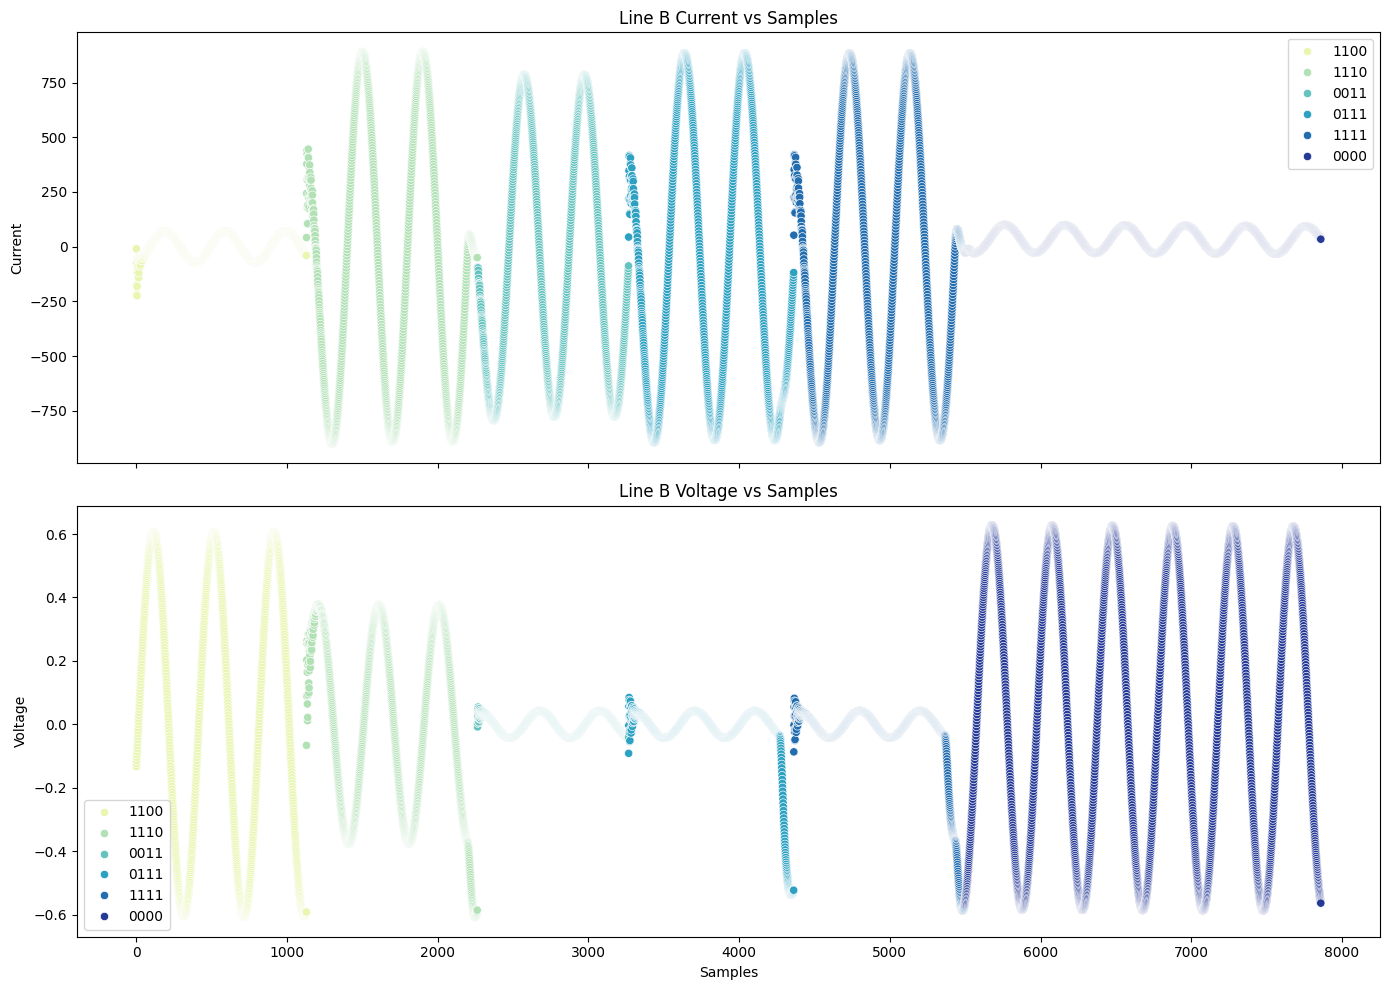

In [38]:
palette = sns.color_palette("YlGnBu", n_colors=6)

# Create the scatter plots
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(14, 10))

sns.scatterplot(data=multiclass_data, y="Ib", x=multiclass_data.index, hue='fault_class', palette=palette, ax=axs[0])
sns.scatterplot(data=multiclass_data, y="Vb", x=multiclass_data.index, hue='fault_class', palette=palette, ax=axs[1])

# Set labels and titles
axs[0].set_ylabel("Current")
axs[0].set_title("Line B Current vs Samples")
axs[1].set_ylabel("Voltage")
axs[1].set_title("Line B Voltage vs Samples")

plt.xlabel("Samples")

# Customize legends
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, labels)
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, labels)

plt.tight_layout()
plt.show()

- **Current Observation:** The Line B current shows distinct oscillatory patterns for different fault classes, with each class exhibiting unique amplitudes and frequencies, indicating varying impacts of fault classes on current behavior.
- **Voltage Observation:** The Line B voltage also displays significant variations across different fault classes, with noticeable changes in waveform amplitude and phase, highlighting the influence of fault conditions on voltage characteristics.

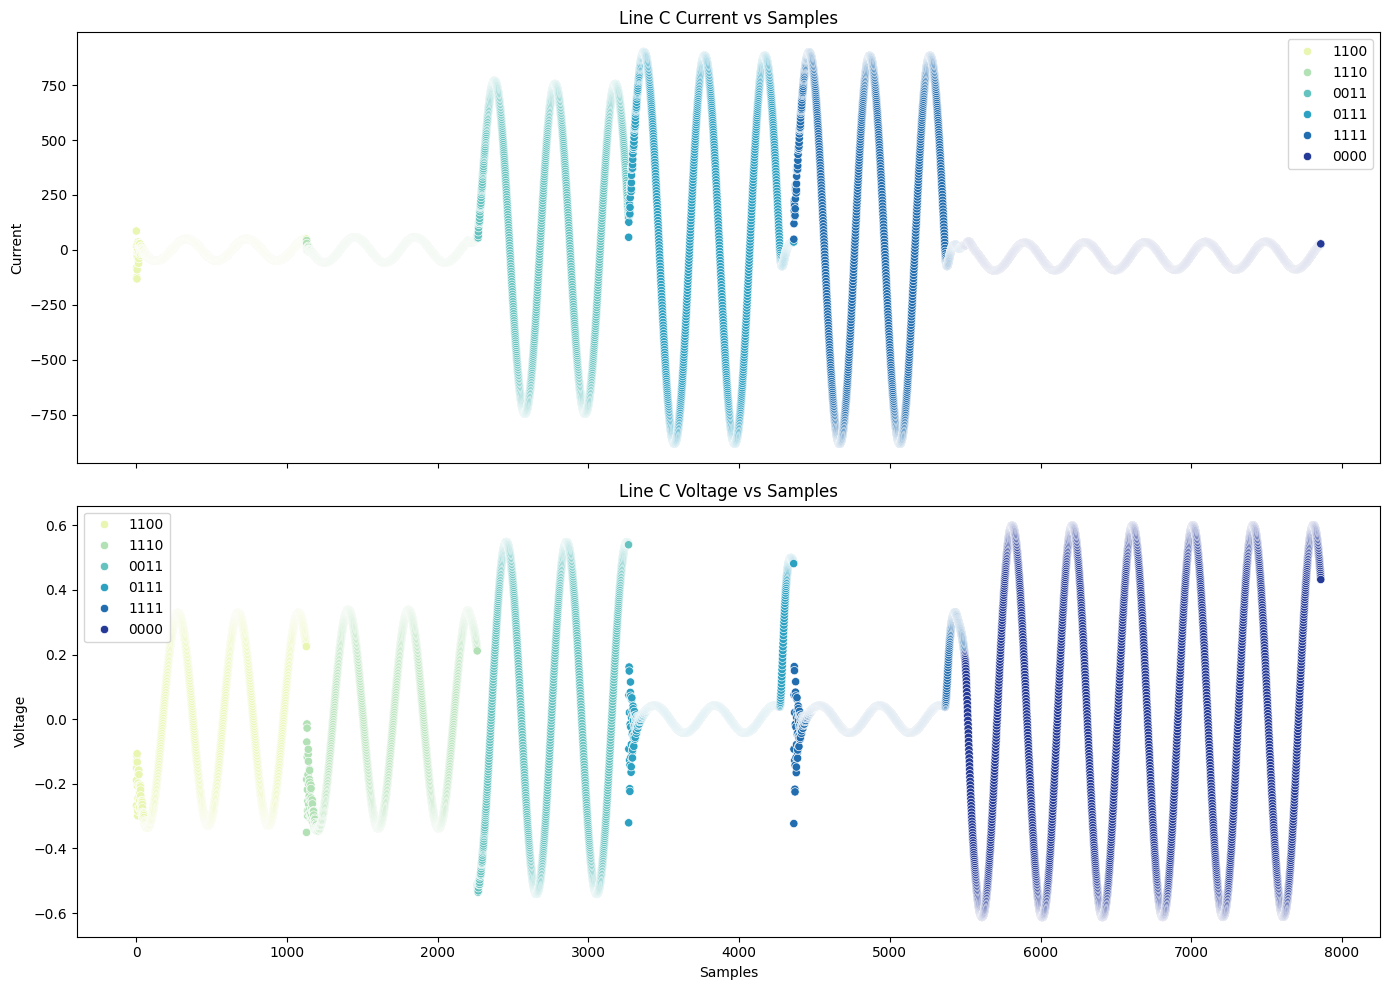

In [39]:
palette = sns.color_palette("YlGnBu", n_colors=6)

# Create the scatter plots
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(14, 10))

sns.scatterplot(data=multiclass_data, y="Ic", x=multiclass_data.index, hue='fault_class', palette=palette, ax=axs[0])
sns.scatterplot(data=multiclass_data, y="Vc", x=multiclass_data.index, hue='fault_class', palette=palette, ax=axs[1])

# Set labels and titles
axs[0].set_ylabel("Current")
axs[0].set_title("Line C Current vs Samples")
axs[1].set_ylabel("Voltage")
axs[1].set_title("Line C Voltage vs Samples")

plt.xlabel("Samples")

# Customize legends
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, labels)
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, labels)

plt.tight_layout()
plt.show()

- **Current Observation:** The Line C current shows different oscillatory patterns and amplitudes for various fault classes, indicating that each fault class uniquely affects the current's behavior.
  
- **Voltage Observation:** The Line C voltage exhibits significant waveform variations across different fault classes, with distinct amplitude and phase shifts, reflecting the impact of fault conditions on the voltage characteristics.

<Axes: >

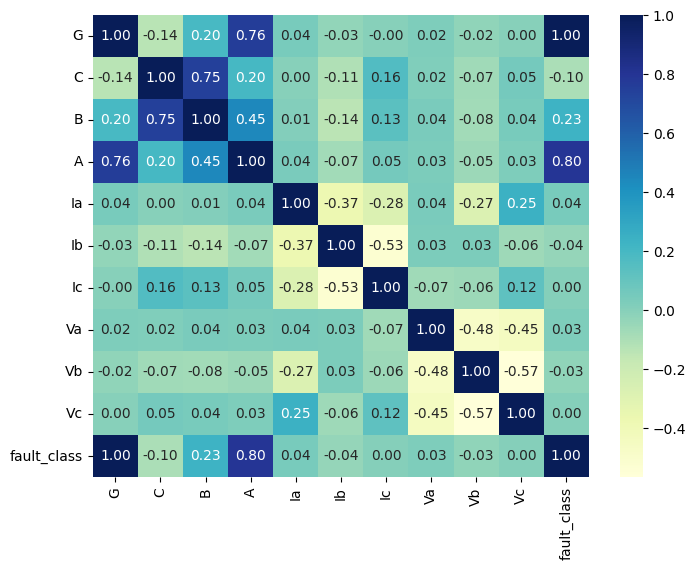

In [40]:
plt.figure(figsize=(8, 6))
sns.heatmap(multiclass_data.corr(), cmap='YlGnBu', fmt='.2f', annot=True)

The correlation heatmap reveals several key insights into the relationships between the variables in the dataset:

1. The fault class is highly correlated with the currents in Line G (1.00) and Line A (0.80), indicating these lines are significantly impacted during fault conditions.
   
2. The currents in Line Ib (-0.37) and Line Ic (-0.53) exhibit negative correlations with the fault class, suggesting that higher currents in these lines are less likely to coincide with fault conditions.

3. There are notable positive correlations between the currents in different lines, particularly between Line G and Line A (0.76) and Line B and Line C (0.75), indicating interconnected behaviors across the transmission lines during faults.

4. The voltages (Va, Vb, Vc) show weaker correlations with the fault class, implying that while faults impact voltage, the effect is less pronounced compared to current variations.


# Build Machine Learning Model

In our dataset, each line (G, A, B, C) has a corresponding output fault. Additionally, we've created a new composite target output called 'fault_class,' representing the current fault across the four lines. This allows us to explore training approaches using either a multioutput model or a multi-label model. We will evaluate and compare the performance of both techniques.

# Multi-label Classification 

In [41]:
data = multiclass_data.copy()
target = data["fault_class"]
X = data.drop(["G", "A", "B", "C", "fault_class"], axis=1)
X.head(2)

Ia         Ib         Ic        Va        Vb        Vc
0 -151.291812  -9.677452  85.800162  0.400750 -0.132935 -0.267815
1 -336.186183 -76.283262  18.328897  0.312732 -0.123633 -0.189099

In [42]:
encoder = LabelEncoder()
Y = encoder.fit_transform(target)
Y

array([3, 3, 3, ..., 0, 0, 0])

In [43]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [44]:
classes_labels = list(encoder.classes_)

# keep track of precision, recall scores
precision_scores = {}
recall_scores = {}

def plot_classification_result(model, y_test, y_pred):
    precision_scores[model] = np.round(np.array(precision_score(y_test, y_pred, average=None)), 2)
    recall_scores[model] = np.round(np.array(recall_score(y_test, y_pred, average=None)), 2)
    print("Average accuracy score: ", accuracy_score(y_test, y_pred))
    print("Metrics table:\n", classification_report(y_test, y_pred, target_names=classes_labels))
    print("Confusion matrix:\n")
    matrix = confusion_matrix(y_test, y_pred)
    matrix = pd.DataFrame(matrix, index=classes_labels, columns=classes_labels)
    plt.figure(figsize=(6, 4))
    plot = sns.heatmap(matrix, cmap='YlGnBu', fmt='.2f', annot=True)
    plot.set_xlabel('Predicted')
    plot.set_ylabel('Real')

# Logistic Regression Model

Average accuracy score:  0.32994278448823905
Metrics table:
               precision    recall  f1-score   support

        0000       0.34      1.00      0.51       485
        0011       0.00      0.00      0.00       219
        0111       0.00      0.00      0.00       209
        1100       0.00      0.00      0.00       214
        1110       0.00      0.00      0.00       240
        1111       0.24      0.17      0.20       206

    accuracy                           0.33      1573
   macro avg       0.10      0.19      0.12      1573
weighted avg       0.14      0.33      0.18      1573

Confusion matrix:



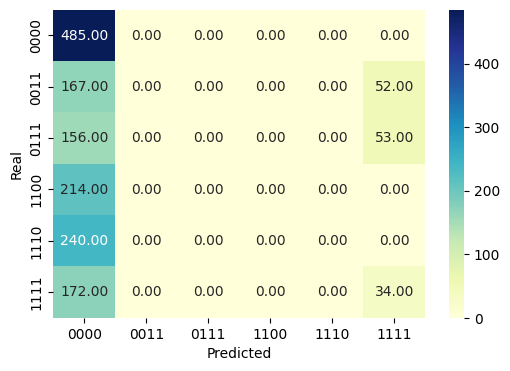

In [45]:
lrg_clf = LogisticRegression(multi_class='auto', max_iter=1000)
lrg_clf.fit(x_train, y_train)
y_pred = lrg_clf.predict(x_test)
plot_classification_result("Logistic regression", y_test, y_pred)

The classification model demonstrates poor performance with an overall accuracy of 33%, and most fault classes show zero precision and recall, indicating significant issues with model predictions across multiple fault types.

# Support Vector Machine

Average accuracy score:  0.7565162110616656
Metrics table:
               precision    recall  f1-score   support

        0000       0.90      1.00      0.95       485
        0011       0.79      0.90      0.84       219
        0111       0.48      0.24      0.32       209
        1100       0.75      0.86      0.80       214
        1110       0.74      0.78      0.76       240
        1111       0.48      0.42      0.45       206

    accuracy                           0.76      1573
   macro avg       0.69      0.70      0.69      1573
weighted avg       0.73      0.76      0.74      1573

Confusion matrix:



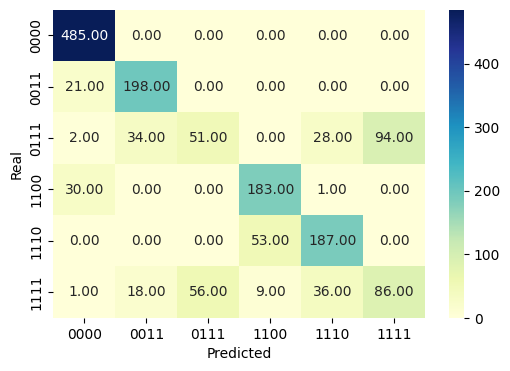

In [46]:
svc_clf = SVC()
svc_clf.fit(x_train, y_train)
y_pred = svc_clf.predict(x_test)
plot_classification_result("SVC", y_test, y_pred)

The model achieves a moderate accuracy of 76%, with high precision and recall for some fault classes, but performance varies significantly across different classes, indicating room for improvement in fault classification.

# Decision Tree Classifier

Average accuracy score:  0.8715829624920534
Metrics table:
               precision    recall  f1-score   support

        0000       1.00      1.00      1.00       485
        0011       1.00      1.00      1.00       219
        0111       0.53      0.53      0.53       209
        1100       0.99      1.00      1.00       214
        1110       0.99      1.00      0.99       240
        1111       0.51      0.50      0.51       206

    accuracy                           0.87      1573
   macro avg       0.84      0.84      0.84      1573
weighted avg       0.87      0.87      0.87      1573

Confusion matrix:



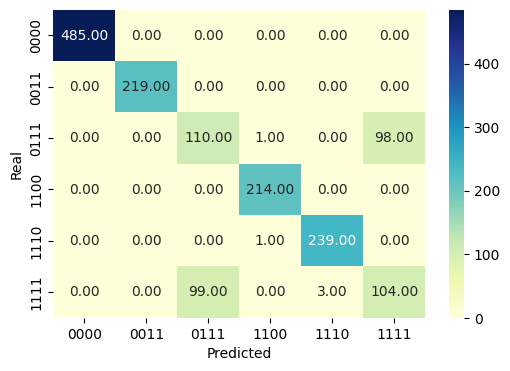

In [47]:
tree_clf = DecisionTreeClassifier(random_state=1)
tree_clf.fit(x_train, y_train)
y_pred = tree_clf.predict(x_test)
plot_classification_result("Decision tree", y_test, y_pred)

The Decision Tree Classifier achieves a strong performance with an accuracy of 87%, demonstrating high precision and recall for most fault classes, though there is still variability in performance across different classes.

# Random Forest Classifier

Average accuracy score:  0.8684043229497775
Metrics table:
               precision    recall  f1-score   support

        0000       1.00      1.00      1.00       485
        0011       1.00      1.00      1.00       219
        0111       0.51      0.52      0.51       209
        1100       1.00      1.00      1.00       214
        1110       0.99      1.00      1.00       240
        1111       0.50      0.49      0.50       206

    accuracy                           0.87      1573
   macro avg       0.83      0.83      0.83      1573
weighted avg       0.87      0.87      0.87      1573

Confusion matrix:



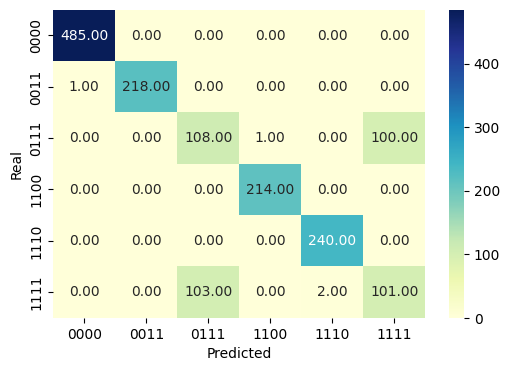

In [48]:
rf_clf = RandomForestClassifier(n_estimators=200, max_features=5, random_state=1)
rf_clf.fit(x_train, y_train)
y_pred = rf_clf.predict(x_test)
plot_classification_result("Random forest", y_test, y_pred)

The model demonstrates robust performance with an accuracy of 87%, exhibiting high precision and recall for most fault classes, though some variability remains in detecting specific fault types.

# XGBoost Classifier

Average accuracy score:  0.821360457724094
Metrics table:
               precision    recall  f1-score   support

        0000       1.00      1.00      1.00       485
        0011       1.00      1.00      1.00       219
        0111       0.31      0.26      0.28       209
        1100       0.99      1.00      1.00       214
        1110       0.98      0.99      0.99       240
        1111       0.35      0.39      0.37       206

    accuracy                           0.82      1573
   macro avg       0.77      0.77      0.77      1573
weighted avg       0.82      0.82      0.82      1573

Confusion matrix:



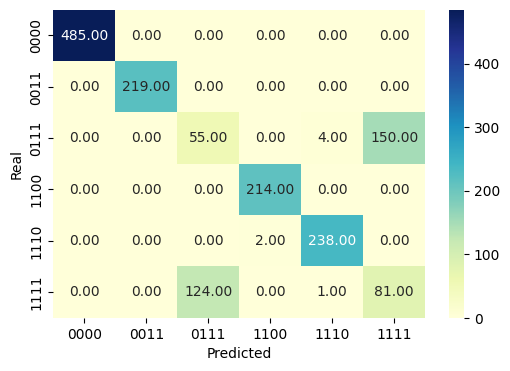

In [49]:
xgb_clf = XGBClassifier(n_estimators=200, max_depth=20, random_state=1)
xgb_clf.fit(x_train, y_train)
y_pred = xgb_clf.predict(x_test)
plot_classification_result("XGBoost", y_test, y_pred)

The model achieves a solid performance with an accuracy of 82%, showing high precision and recall for some fault classes, though there is notable variability in correctly identifying certain fault types, as indicated by the confusion matrix.

# Result Analysis

## Model precision results

In [50]:
precision_results = pd.DataFrame(precision_scores, index=classes_labels)
precision_results.T

0000  0011  0111  1100  1110  1111
Logistic regression  0.34  0.00  0.00  0.00  0.00  0.24
SVC                  0.90  0.79  0.48  0.75  0.74  0.48
Decision tree        1.00  1.00  0.53  0.99  0.99  0.51
Random forest        1.00  1.00  0.51  1.00  0.99  0.50
XGBoost              1.00  1.00  0.31  0.99  0.98  0.35


- Logistic Regression shows very low precision across most fault classes, indicating a high number of false positives.
  
- Support Vector Classifier (SVC) has moderate precision, particularly high for class '0000' but lower for other classes.
  
- Decision Tree and Random Forest classifiers demonstrate high precision across all fault classes, except for class '0111' and '1111', where performance drops.
  
- XGBoost also shows high precision for most classes, with slightly lower performance for class '0111' and '1111'.


## Model recall results

In [51]:
recall_results = pd.DataFrame(recall_scores, index=classes_labels)
recall_results.T

0000  0011  0111  1100  1110  1111
Logistic regression   1.0   0.0  0.00  0.00  0.00  0.17
SVC                   1.0   0.9  0.24  0.86  0.78  0.42
Decision tree         1.0   1.0  0.53  1.00  1.00  0.50
Random forest         1.0   1.0  0.52  1.00  1.00  0.49
XGBoost               1.0   1.0  0.26  1.00  0.99  0.39

- Logistic Regression has perfect recall for class '0000' but zero recall for other classes, indicating it only correctly identifies the majority class.

- SVC achieves good recall for several classes, especially '0000', '1100', and '1110', but struggles with '0111' and '1111'.
  
- Decision Tree and Random Forest classifiers maintain high recall for most classes, indicating they correctly identify faults in these categories, though '0111' and '1111' are still challenging.
  
- XGBoost provides strong recall for most classes, particularly '0000', '1100', and '1110', but lower recall for '0111' and '1111', similar to other models.


# Random Forest Model Fine Tuning

In [52]:
import optuna

In [53]:

def objective(trial):
    params = {
    "n_estimators": trial.suggest_int('n_estimators', 10, 200),
    "max_depth" : trial.suggest_int('max_depth', 2, 32),
    "min_samples_split" : trial.suggest_int('min_samples_split', 2, 20),
    "min_samples_leaf" : trial.suggest_int('min_samples_leaf', 1, 20)

    }

    model = RandomForestClassifier(**params)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    rmse = accuracy_score(y_test, predictions)
    return rmse

In [54]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-07-03 16:15:21,959] A new study created in memory with name: no-name-f371262a-4d6c-4f4b-a549-539beb889ab2
[I 2024-07-03 16:15:22,948] Trial 0 finished with value: 0.8169103623649078 and parameters: {'n_estimators': 117, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.8169103623649078.
[I 2024-07-03 16:15:24,215] Trial 1 finished with value: 0.8169103623649078 and parameters: {'n_estimators': 153, 'max_depth': 31, 'min_samples_split': 14, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.8169103623649078.
[I 2024-07-03 16:15:24,635] Trial 2 finished with value: 0.8041958041958042 and parameters: {'n_estimators': 57, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.8169103623649078.
[I 2024-07-03 16:15:25,617] Trial 3 finished with value: 0.7978385251112524 and parameters: {'n_estimators': 186, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with valu

In [55]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 11, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 14}
Best RMSE: 0.8308963763509218


In [56]:
tuned_rf = RandomForestClassifier(**study.best_params)
tuned_rf.fit(x_train, y_train)
y_pred = tuned_rf.predict(x_test)

Average accuracy score:  0.8296249205340115
Metrics table:
               precision    recall  f1-score   support

        0000       0.99      1.00      1.00       485
        0011       1.00      0.99      0.99       219
        0111       0.38      0.35      0.37       209
        1100       0.96      1.00      0.98       214
        1110       0.97      0.97      0.97       240
        1111       0.38      0.40      0.39       206

    accuracy                           0.83      1573
   macro avg       0.78      0.79      0.78      1573
weighted avg       0.83      0.83      0.83      1573

Confusion matrix:



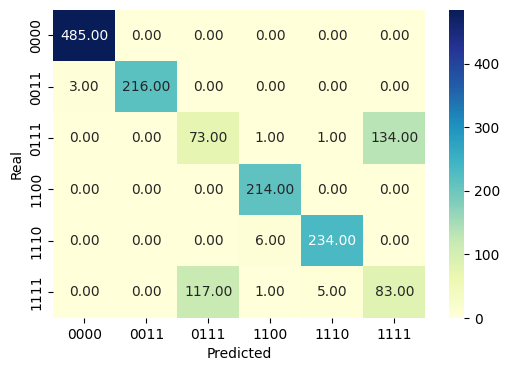

In [57]:
plot_classification_result("Random Forest tuned", y_test, y_pred)

- The tuned Random Forest Classifier achieves an accuracy of 82%, with high precision and recall for most fault classes, though it struggles with correctly identifying classes '0111' and '1111'. 
- The hyperparameter tuning significantly improves performance, particularly for classes '0000', '0011', '1100', and '1110'.

# Multi Output Classification

In [58]:
data = multiclass_data.copy()
Y = data[["G", "A", "B", "C"]]
X = data.drop(["G", "A", "B", "C", "fault_class"], axis=1)
# Split the dataset: Training(80%), Testing(20%)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
outputs = ["Ground", "Line A", "Line B", "Line C"]

def multioutput_perfomance_logs(y_true, y_test):
    print("Average accuracy score: ", accuracy_score(y_true, y_pred))
    for i in range(y_true.shape[1]):
        print(f"{outputs[i]} Fault Classification Report:")
        report = classification_report(np.array(y_true)[:, i], y_pred[:, i])
        print(report)
        print("="*50)

## Decision Tree Classifier

In [59]:
tree = RandomForestClassifier(random_state=1)
multi_tree = MultiOutputClassifier(tree, n_jobs=-1)
multi_tree.fit(x_train, y_train)
y_pred = multi_tree.predict(x_test)
multioutput_perfomance_logs(y_test, y_pred)


Average accuracy score:  0.8684043229497775
Ground Fault Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       889
           1       0.86      0.84      0.85       684

    accuracy                           0.87      1573
   macro avg       0.87      0.87      0.87      1573
weighted avg       0.87      0.87      0.87      1573

Line A Fault Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       666
           1       1.00      1.00      1.00       907

    accuracy                           1.00      1573
   macro avg       1.00      1.00      1.00      1573
weighted avg       1.00      1.00      1.00      1573

Line B Fault Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       690
           1       1.00      0.99      1.00       883

    accuracy                  

- **Ground Fault Classification:** The model achieves an average accuracy of 87%, with high precision (0.88) and recall (0.90) for no-fault conditions, and slightly lower precision (0.86) and recall (0.84) for fault conditions.
- **Line A Fault Classification:** The model demonstrates perfect classification performance for Line A faults, achieving 100% precision, recall, and F1-score for both fault and no-fault conditions, indicating reliable detection.
- **Line B and Line C Fault Classification:** The model also performs exceptionally well for Line B and Line C faults, with near-perfect precision, recall, and F1-scores close to 100%, ensuring accurate identification of faults in these lines.

## Random Forest Classifier

In [60]:
forest = RandomForestClassifier(random_state=1)
multi_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_forest.fit(x_train, y_train)
y_pred = multi_forest.predict(x_test)
multioutput_perfomance_logs(y_test, y_pred)

Average accuracy score:  0.8684043229497775
Ground Fault Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       889
           1       0.86      0.84      0.85       684

    accuracy                           0.87      1573
   macro avg       0.87      0.87      0.87      1573
weighted avg       0.87      0.87      0.87      1573

Line A Fault Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       666
           1       1.00      1.00      1.00       907

    accuracy                           1.00      1573
   macro avg       1.00      1.00      1.00      1573
weighted avg       1.00      1.00      1.00      1573

Line B Fault Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       690
           1       1.00      0.99      1.00       883

    accuracy                  

- **Ground Fault Classification:** The model achieves an overall accuracy of 87%, with a precision of 0.88 and recall of 0.90 for no-fault conditions, and a precision of 0.86 and recall of 0.84 for fault conditions, indicating strong performance but with some variability.
- **Line A Fault Classification:** The model shows perfect precision, recall, and F1-scores of 1.00 for both fault and no-fault conditions, indicating it accurately identifies all Line A faults.
- **Line B and Line C Fault Classification:** Similarly, the model demonstrates nearly perfect classification performance for Line B and Line C faults, with precision, recall, and F1-scores close to 1.00, ensuring reliable fault detection for these lines.

## XGBoost Classifier

In [61]:
xgboost = XGBClassifier(random_state=1)
multi_xgboost = MultiOutputClassifier(xgboost, n_jobs=-1)
multi_xgboost.fit(x_train, y_train)
y_pred = multi_xgboost.predict(x_test)
multioutput_perfomance_logs(y_test, y_pred)

Average accuracy score:  0.7927527018436109
Ground Fault Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       889
           1       0.77      0.75      0.76       684

    accuracy                           0.79      1573
   macro avg       0.79      0.79      0.79      1573
weighted avg       0.79      0.79      0.79      1573

Line A Fault Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       666
           1       1.00      1.00      1.00       907

    accuracy                           1.00      1573
   macro avg       1.00      1.00      1.00      1573
weighted avg       1.00      1.00      1.00      1573

Line B Fault Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       690
           1       1.00      1.00      1.00       883

    accuracy                  

- **Ground Fault Classification:** The model achieves an overall accuracy of 79%, with a precision of 0.81 and recall of 0.83 for no-fault conditions, and a precision of 0.77 and recall of 0.75 for fault conditions, showing moderate performance.
- **Line A Fault Classification:** The model shows perfect precision, recall, and F1-scores of 1.00 for both fault and no-fault conditions, indicating it accurately identifies all Line A faults.
- **Line B and Line C Fault Classification:** Similarly, the model demonstrates perfect classification performance for Line B and Line C faults, with precision, recall, and F1-scores of 1.00, ensuring reliable fault detection for these lines.